# UBI车险模型
数据源: 第三方数据源（已经过清洗和处理） <br>
案例参考：https://blog.csdn.net/weixin_39593469/article/details/112510661?utm_medium=distribute.pc_relevant.none-task-blog-2~default~baidujs_utm_term~default-1-112510661-blog-60866782.235<br>
http://erepository.uonbi.ac.ke/bitstream/handle/11295/154304/Masese_Application%20of%20generalized%20linear%20Models%20in%20Pricing%20Usage-Based%20Insurance.pdf?sequence=1<br>
作者：夏伯平、张哲宁 <br>

故事背景：[*待补充*]<br>
在一般线性回归中，目标值$y$与特征向量$x_1$，$x_2$，……，$x_n$的线性关系可表述为$$E(y) = b_0 + b_1x_1 + b_2x_2 + ... + b_nx_n$$
而在实际情况中，目标值$y$与特征向量$x_1$，$x_2$，……，$x_n$的关系可能不为线性：如$y$为二元分类（0或1）或离散数据（事件发生次数），这时我们不能使用一般线性回归。但如果我们能通过某种变换，重新使目标值$y$与特征向量$x_1$，$x_2$，……，$x_n$产生线性关系，我们便能使用最小二乘法或最大似然估计计算出对应的系数。这便是广义线性回归。<br>
广义线性回归中，使目标值$y$发生变换的函数称为链接函数$g(·)$，此时目标值$y$与特征向量$x_1$，$x_2$，……，$x_n$的线性关系可表述为$$g(E(y)) = b_0 + b_1x_1 + b_2x_2 + ... + b_nx_n$$
此时我们的预测值的计算方式为$$E(\hat{y}) = g^{-1}(b_0 + b_1x_1 + b_2x_2 + ... + b_nx_n)$$

**目录**
1. 数据导入以及相关性分析
2. 广义线性模型拟合及分析
3. 根据回归模型计算预期保费

## 1. 数据导入以及相关性分析

In [2]:
# 导入相关工具库
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# 忽略警告信息（可选）
import warnings
warnings.filterwarnings("ignore")

# matplotlib参数设置，显示中文和字号12
matplotlib.rcParams['font.family'] = 'Microsoft Yahei'
plt.rc('font', size=12)

### 1.1 数据导入

In [42]:
# 导入数据
data_raw = pd.read_csv('客户信息.csv') 
# 查看数据前5行
data_raw.head(5)

,ID,出生日期,性别,婚姻状况,学历,用车区域,车辆用途,车辆价值,车辆类别,年平均里程,年平均车速,主要行车时间,出险频率,出险强度
0,63581743,1939/3/16,男,未婚,博士,城镇,个人,10-20万,MPV,5千-1万,60-79,日间,1,848
1,132761049,1956/1/21,男,未婚,高中,城镇,单位,10-20万,MPV,小于5千,60-79,日间,0,182
2,921317019,1951/11/18,男,未婚,本科,城镇,个人,20-30万,厢式货车,1万-1万5,60-79,夜间,0,1915
3,727598473,1964/3/5,女,已婚,高中,城镇,个人,小于10万,SUV,1万5-2万,80-99,夜间,5,681
4,450221861,1948/6/5,男,已婚,高中以下,城镇,个人,10-20万,MPV,小于5千,小于40,日间,0,63


In [43]:
# 使用info()函数对数据表进行初步预览
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10302 non-null  int64 
 1   出生日期    10302 non-null  object
 2   性别      10302 non-null  object
 3   婚姻状况    10302 non-null  object
 4   学历      10302 non-null  object
 5   用车区域    10302 non-null  object
 6   车辆用途    10302 non-null  object
 7   车辆价值    10302 non-null  object
 8   车辆类别    10302 non-null  object
 9   年平均里程   10302 non-null  object
 10  年平均车速   10302 non-null  object
 11  主要行车时间  10302 non-null  object
 12  出险频率    10302 non-null  int64 
 13  出险强度    10302 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.1+ MB


该数据表包含10302条记录，其中多数列为类别数据。对于UBI模型，我们将从中选取可能与出险相关的驾驶员信息作为特征进行拟合。出于简化演示过程考虑，我们仅选取`用车区域`、`年平均里程`、`年平均车速`、`主要行车时间`这四个特征。

In [61]:
# 选取特征和目标
data = data_raw[['用车区域', '年平均里程', '年平均车速', '主要行车时间', '出险频率', '出险强度']]
# 查看数据前5行
data.head(5)

,用车区域,年平均里程,年平均车速,主要行车时间,出险频率,出险强度
0,城镇,5千-1万,60-79,日间,1,848
1,城镇,小于5千,60-79,日间,0,182
2,城镇,1万-1万5,60-79,夜间,0,1915
3,城镇,1万5-2万,80-99,夜间,5,681
4,城镇,小于5千,小于40,日间,0,63


In [10]:
# 查看每列特征的可取值
print("用车区域的可取值为：{}".format(data['用车区域'].unique()))
print("年平均里程的可取值为：{}".format(data['年平均里程'].unique()))
print("年平均车速的可取值为：{}".format(data['年平均车速'].unique()))
print("主要行车时间的可取值为：{}".format(data['主要行车时间'].unique()))

用车区域的可取值为：['城镇' '农村']
年平均里程的可取值为：['5千-1万' '小于5千' '1万-1万5' '1万5-2万' '大于2万']
年平均车速的可取值为：['60-79' '80-99' '小于40' '40-59' '大于100']
主要行车时间的可取值为：['日间' '夜间']


### 1.2 相关性分析
由于回归是对目标值的期望进行计算，所以在相关性分析中我们将使用每一特征分类对应的目标平均值进行分析

#### 1.2.1 出险频率与年平均里程

<AxesSubplot:xlabel='年平均里程', ylabel='出险频率'>

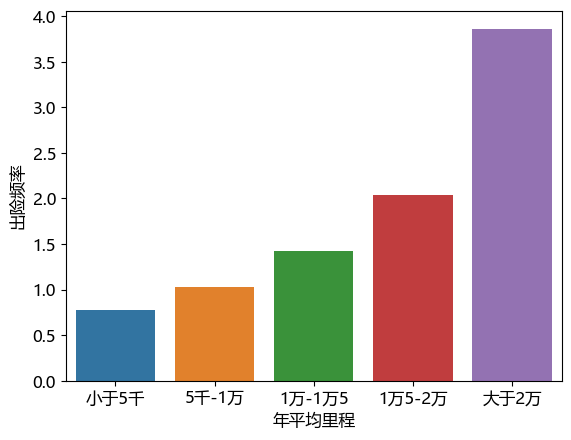

In [67]:
# 使用groupby函数对所选类别进行聚合，mean()为聚合后计算平均值
# reset_index()重置聚合后数据表的索引值
mile_freq = data.groupby('年平均里程').mean().reset_index()
# Categorical()函数告知pandas该数据表中的某一列为类别数据以及对应的类别（categories）
mf_order = ['小于5千', '5千-1万', '1万-1万5', '1万5-2万', '大于2万']
mile_freq['年平均里程'] = pd.Categorical(mile_freq['年平均里程'], categories=mf_order)
# 绘制条形图查看年平均里程和出险频率的关系
sns.barplot(data=mile_freq, x='年平均里程', y='出险频率')

由图可以看出，出险频率随着里程数的增加而增加

#### 1.2.2 出险频率与年平均车速

<AxesSubplot:xlabel='年平均车速', ylabel='出险频率'>

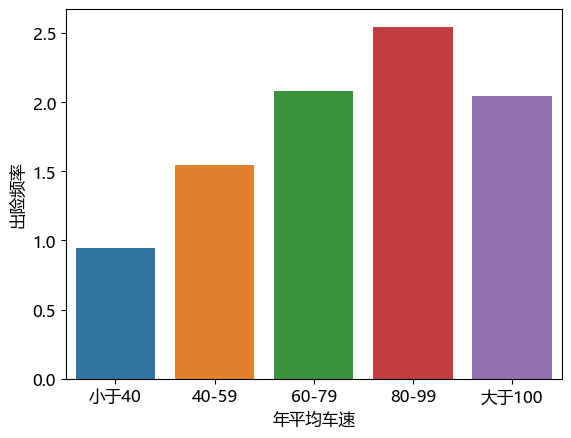

In [68]:
# 聚合取平均并重新排序
speed_freq = data.groupby('年平均车速').mean().reset_index()
sf_order = ['小于40', '40-59', '60-79', '80-99', '大于100']
speed_freq['年平均车速'] = pd.Categorical(speed_freq['年平均车速'], categories=sf_order)
# 绘制条形图查看年平均车速和出险频率的关系
sns.barplot(data=speed_freq, x='年平均车速', y='出险频率')

由图可以看出，出险频率随着平均车速的增加而增加，但在100公里每小时后下降

#### 1.2.3 出险频率与主要行车时间

<AxesSubplot:xlabel='主要行车时间', ylabel='出险频率'>

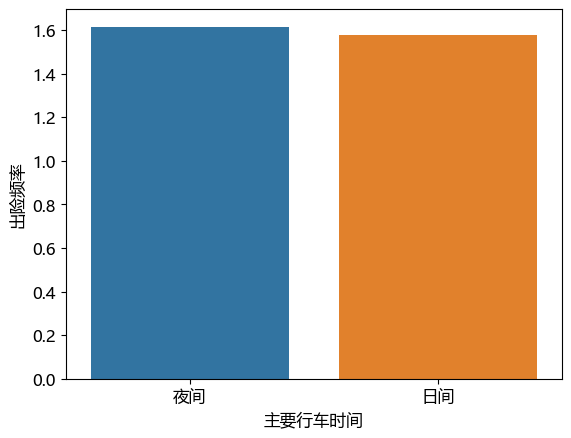

In [12]:
# 聚合取平均
time_freq = data.groupby('主要行车时间').mean().reset_index()
# 绘制条形图查看年主要行车时间和出险频率的关系
sns.barplot(data=time_freq, x='主要行车时间', y='出险频率')

由图可以看出，不同时间段出险频率无明显变化

#### 1.2.4 出险频率与用车区域

<AxesSubplot:xlabel='用车区域', ylabel='出险频率'>

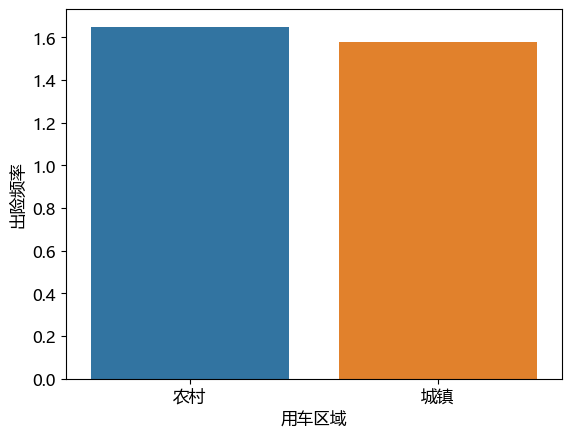

In [13]:
# 聚合取平均
urban_freq = data.groupby('用车区域').mean().reset_index()
# 绘制条形图查看用车区域和出险频率的关系
sns.barplot(data=urban_freq, x='用车区域', y='出险频率')

由图可以看出，不同区域出险频率无明显变化

#### 1.2.5 出险强度与年平均里程

<AxesSubplot:xlabel='年平均里程', ylabel='出险强度'>

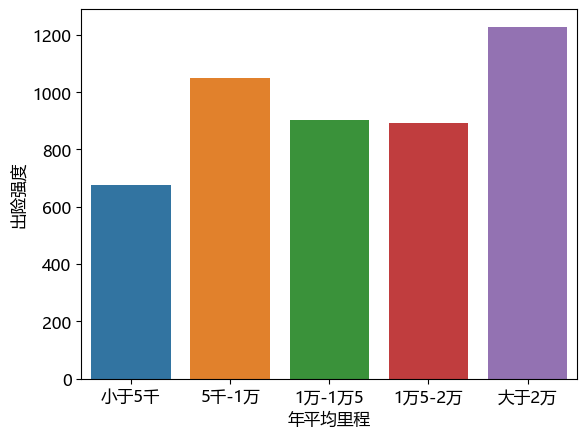

In [69]:
# 聚合取平均并重新排序
mile_seve = data.groupby("年平均里程").mean().reset_index()
ms_order = ['小于5千', '5千-1万', '1万-1万5', '1万5-2万', '大于2万']
mile_seve['年平均里程'] = pd.Categorical(mile_seve['年平均里程'], categories=ms_order)
# 绘制条形图查看年平均里程和出险强度的关系
sns.barplot(data=mile_seve, x='年平均里程', y='出险强度')

由图可以看出，出险强度随里程增长整体呈上升趋势，但不够显著

#### 1.2.6 出险强度与年平均车速

<AxesSubplot:xlabel='年平均车速', ylabel='出险强度'>

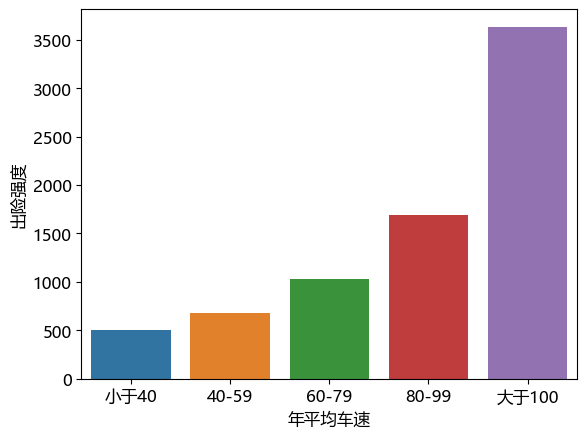

In [70]:
# 聚合取平均并重新排序
speed_seve = data.groupby('年平均车速').mean().reset_index()
ss_order = ['小于40', '40-59', '60-79', '80-99', '大于100']
speed_seve['年平均车速'] = pd.Categorical(speed_seve['年平均车速'], categories=ss_order)
# 绘制条形图查看年平均车速和出险强度的关系
sns.barplot(data=speed_seve, x='年平均车速', y='出险强度')

由图可以看出，出险强度随着车速的增加而增加

#### 1.2.7 出险强度与主要行车时间

<AxesSubplot:xlabel='主要行车时间', ylabel='出险强度'>

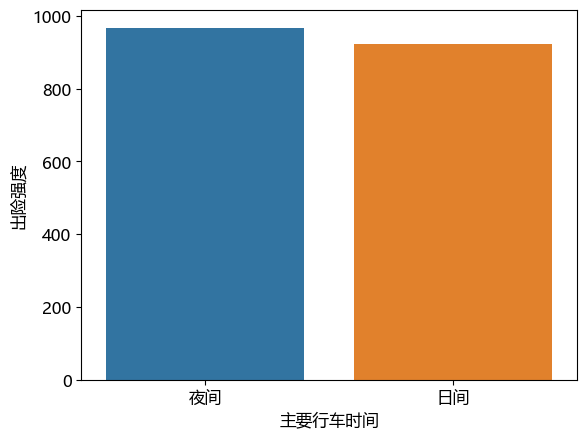

In [16]:
# 聚合取平均
time_seve = data.groupby('主要行车时间').mean().reset_index()
# 绘制条形图查看年主要行车时间和出险强度的关系
sns.barplot(data=time_seve, x='主要行车时间', y='出险强度')

由图可以看出，不同时间段出险强度无明显变化

#### 1.2.8 出险强度与用车区域

<AxesSubplot:xlabel='用车区域', ylabel='出险强度'>

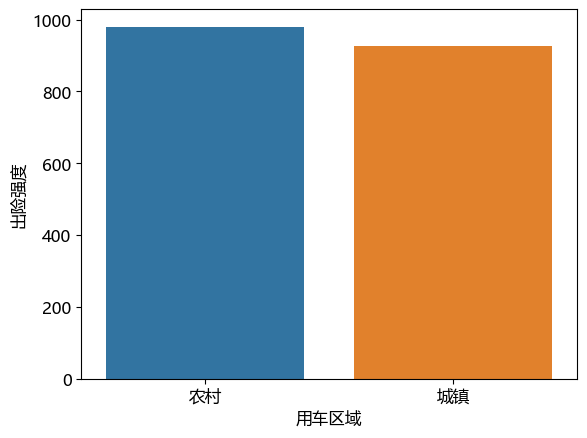

In [17]:
# 聚合取平均
urban_seve = data.groupby('用车区域').mean().reset_index()
# 绘制条形图查看用车区域和出险强度的关系
sns.barplot(data=urban_seve, x='用车区域', y='出险强度')

由图可以看出，不同区域出险强度无明显变化

根据图像分析结果，我们判断出险频率和出险强度均与年平均里程和年平均车速相关，与主要行车时间和用车区域无关。我们会在后面模型拟合报告中进一步验证我们的判断。

## 2. 广义线性模型拟合及模型分析
我们将使用`statsmodels`工具库进行广义线性回归，该工具库包含多种统计模型以及其对应的链接函数。

### 2.1 对特征值进行预处理
由于特征值均为类别变量，我们需要对其进行变换使其能够进行数学计算，其中一种方法是对每一具体类别从小到大编号。但这种方法会抹除每个类别之间的差异性，因此我们选择将包含$n$个类别的类别变量转换为$n-1$个二元分类变量，其又被称为虚拟变量（dummy variable）。因为常数项的存在，我们需要将某种类别定义为基本类别，以避免回归系数没有唯一解（虚拟变量陷阱），因此需转换为$n-1$个虚拟变量。

In [45]:
# 声明年平均里程和年平均车速的类别顺序
mile_order = ['小于5千', '5千-1万', '1万-1万5', '1万5-2万', '大于2万']
speed_order = ['小于40', '40-59', '60-79', '80-99', '大于100']
data['年平均里程'] = pd.Categorical(data['年平均里程'], categories=mile_order)
data['年平均车速'] = pd.Categorical(data['年平均车速'], categories=speed_order)
# 提取特征值
features = data[['年平均里程', '年平均车速', '主要行车时间', '用车区域']]
# statsmodels在回归中不会自动引入常数项，需手动添加一列1让其计算常数项
# 该列名称为const
features = sm.add_constant(features)
# 使用get_dummies将所有类别变量转换为虚拟变量
# drop_first=True使其只保留n-1个虚拟变量
features = pd.get_dummies(features, drop_first=True)
# 查看前5行
display(features.head(5))
# 提取目标值
t_freq = data['出险频率']
t_seve = data['出险强度']

,const,年平均里程_5千-1万,年平均里程_1万-1万5,年平均里程_1万5-2万,年平均里程_大于2万,年平均车速_40-59,年平均车速_60-79,年平均车速_80-99,年平均车速_大于100,主要行车时间_日间,用车区域_城镇
0,1.0,1,0,0,0,0,1,0,0,1,1
1,1.0,0,0,0,0,0,1,0,0,1,1
2,1.0,0,1,0,0,0,1,0,0,0,1
3,1.0,0,0,1,0,0,0,1,0,0,1
4,1.0,0,0,0,0,0,0,0,0,1,1


### 2.2 出险频率模型拟合
由于出险次数是非负的离散随机变量，所以模型中采用泊松分布来进行拟合。泊松分布的生产机理为：<br>
1)在很小的时间区间$(t, t + dt)$内，发生一次出险的概率与时间区间的长度近似成正比，即近似为$ldt$。<br>
2)在很小的时间区间$(t, t + dt)$内，发生两次及其以上出险的概率几乎为零。<br>
3)在不相交的两个时间区间发生的出险次数相互独立。<br>
在车险定价研究中常用的链接函数为对数函数。该链接函数结构比较简单，而且当前汽车保险广泛采用加法和乘法模型，对数函数很容易实现这种变换。`statsmodels`中泊松模型的预设链接函数为对数函数，因此我们不需专门声明。

In [46]:
# 使用statsmodels.GLM()进行广义线性回归
# 第一个输入变量为目标值，第二个输入变量为特征值，family声明数据的分布模型
# fit()进行拟合
freq_glm = sm.GLM(t_freq, features, family=sm.families.Poisson()).fit()
# 使用summary()查看拟合结果
freq_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   出险频率   No. Observations:                10302
Model:                            GLM   Df Residuals:                    10291
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15221.
Date:                Sat, 08 Jul 2023   Deviance:                       11573.
Time:                        06:44:07   Pearson chi2:                 1.03e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4253
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7378      0.039    -18.965      0.000      -0.814      -0.662
年平均里程_5千-1万      0.2837      0.035      8.051      0.000       0.215       0.353
年平均里程_1万-1万5     0.6032      0.033     18.184      0.000       0.538       0.668
年平均里程_1万5-2万     0.9679      0.033     29.049      0.000       0.903       1.033
年平均里程_大于2万       1.5975      0.034     47.416      0.000       1.531       1.664
年平均车速_40-59      0.4758      0.023     20.966      0.000       0.431       0.520
年平均车速_60-79      0.7798      0.024     32.613      0.000       0.733       0.827
年平均车速_80-99      0.9919      0.027     36.569      0.000       0.939       1.045
年平均车速_大于100      0.7203      0.036     20.077      0.000       0.650       0.791
主要行车时间_日间       -0.0144      0.016     -0.879      0.379      -0.046       0.018
用车区域_城镇         -0.0169      0.019     -0.880      0.379      -0.055       0.021
================================================================================
"""

在回归报告中，`coef`一栏可以得到某一类别的系数，`std err`一栏可以得到该系数的标准差，`P>|z|`一栏代表该系数对应的P值。一般P值小于0.05，我们就认为该系数足够显著，从而得出对应特征与目标值高度相关。<br>
该回归报告指出`主要行车时间_日间`和`用车区域_城镇`两项P值大于0.05，说明`主要行车时间`和`用车区域`与出险频率没有显著相关性，与我们先前图像分析相符。其余特征均足够显著相关。

### 2.3 出险强度模型拟合
由于出险强度的分布通常为右偏的，因此模型使用伽玛分布来拟合。`statsmodels`中伽马模型的预设链接函数为负倒数函数，因此我们需专门声明链接函数为对数函数。

In [47]:
# 使用statsmodels.GLM()进行广义线性回归
# link声明链接函数的类型
sever_glm = sm.GLM(t_seve, features, family=sm.families.Gamma(link=sm.families.links.log())).fit()
# 使用summary()查看拟合结果
sever_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   出险强度   No. Observations:                10302
Model:                            GLM   Df Residuals:                    10291
Model Family:                   Gamma   Df Model:                           10
Link Function:                    log   Scale:                         0.99908
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Sat, 08 Jul 2023   Deviance:                       12615.
Time:                        06:44:10   Pearson chi2:                 1.03e+04
No. Iterations:                    10   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.9014      0.039    152.606      0.000       5.826       5.977
年平均里程_5千-1万      0.4561      0.033     14.020      0.000       0.392       0.520
年平均里程_1万-1万5     0.2782      0.032      8.794      0.000       0.216       0.340
年平均里程_1万5-2万     0.3217      0.034      9.444      0.000       0.255       0.388
年平均里程_大于2万       0.5563      0.041     13.553      0.000       0.476       0.637
年平均车速_40-59      0.3065      0.024     12.569      0.000       0.259       0.354
年平均车速_60-79      0.7283      0.028     25.632      0.000       0.673       0.784
年平均车速_80-99      1.2277      0.037     33.614      0.000       1.156       1.299
年平均车速_大于100      1.9777      0.047     41.638      0.000       1.885       2.071
主要行车时间_日间       -0.0121      0.021     -0.583      0.560      -0.053       0.028
用车区域_城镇         -0.0174      0.025     -0.709      0.478      -0.066       0.031
================================================================================
"""

该回归报告指出`主要行车时间_日间`和`用车区域_城镇`两项P值大于0.05，说明`主要行车时间`和`用车区域`与出险强度没有显著相关性，与我们先前图像分析相符。其余特征均足够显著相关。
根据图像分析和回归报告，我们判断`主要行车时间`和`用车区域`两项与出险频率和出险强度均无明显相关性，因此将其从模型中剔除并重新拟合

### 2.4 最终模型

In [50]:
# 提取特征值
features_f = data[['年平均里程', '年平均车速']]
# 加入常数项
features_f = sm.add_constant(features_f)
# 转换为虚拟变量
features_f = pd.get_dummies(features_f, drop_first=True)
# 查看前5行
display(features_f.head(5))

,const,年平均里程_5千-1万,年平均里程_1万-1万5,年平均里程_1万5-2万,年平均里程_大于2万,年平均车速_40-59,年平均车速_60-79,年平均车速_80-99,年平均车速_大于100
0,1.0,1,0,0,0,0,1,0,0
1,1.0,0,0,0,0,0,1,0,0
2,1.0,0,1,0,0,0,1,0,0
3,1.0,0,0,1,0,0,0,1,0
4,1.0,0,0,0,0,0,0,0,0


In [51]:
# 出险频率模型
freq_f_glm = sm.GLM(t_freq, features_f, family=sm.families.Poisson()).fit()
# 使用summary()查看拟合结果
freq_f_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   出险频率   No. Observations:                10302
Model:                            GLM   Df Residuals:                    10293
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15222.
Date:                Sat, 08 Jul 2023   Deviance:                       11575.
Time:                        06:44:46   Pearson chi2:                 1.03e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4253
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7613      0.034    -22.491      0.000      -0.828      -0.695
年平均里程_5千-1万      0.2841      0.035      8.061      0.000       0.215       0.353
年平均里程_1万-1万5     0.6037      0.033     18.199      0.000       0.539       0.669
年平均里程_1万5-2万     0.9683      0.033     29.065      0.000       0.903       1.034
年平均里程_大于2万       1.5981      0.034     47.440      0.000       1.532       1.664
年平均车速_40-59      0.4759      0.023     20.970      0.000       0.431       0.520
年平均车速_60-79      0.7804      0.024     32.645      0.000       0.734       0.827
年平均车速_80-99      0.9920      0.027     36.577      0.000       0.939       1.045
年平均车速_大于100      0.7209      0.036     20.098      0.000       0.651       0.791
================================================================================
"""

In [52]:
# 出险强度模型
sever_f_glm = sm.GLM(t_seve, features_f, family=sm.families.Gamma(link=sm.families.links.log())).fit()
# 使用summary()查看拟合结果
sever_f_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   出险强度   No. Observations:                10302
Model:                            GLM   Df Residuals:                    10293
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.99940
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Sat, 08 Jul 2023   Deviance:                       12616.
Time:                        06:44:52   Pearson chi2:                 1.03e+04
No. Iterations:                    10   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.8792      0.030    196.369      0.000       5.820       5.938
年平均里程_5千-1万      0.4566      0.033     14.035      0.000       0.393       0.520
年平均里程_1万-1万5     0.2789      0.032      8.817      0.000       0.217       0.341
年平均里程_1万5-2万     0.3219      0.034      9.450      0.000       0.255       0.389
年平均里程_大于2万       0.5572      0.041     13.577      0.000       0.477       0.638
年平均车速_40-59      0.3061      0.024     12.551      0.000       0.258       0.354
年平均车速_60-79      0.7286      0.028     25.641      0.000       0.673       0.784
年平均车速_80-99      1.2279      0.037     33.617      0.000       1.156       1.299
年平均车速_大于100      1.9785      0.048     41.651      0.000       1.885       2.072
================================================================================
"""

## 3. 根据回归模型计算预期保费

In [64]:
# 创建原数据表的复制防止对原数据表产生改动
result = data.copy()
# 使用predict()函数输入特征值得到对应的预测结果
result['预期出险频率'] = freq_f_glm.predict(features_f)
result['预期出险强度'] = sever_f_glm.predict(features_f)
# 预期保费 = 预期出险频率 * 预期出险强度
result['预期保费'] = result['预期出险频率'] * result['预期出险强度']
# 查看数据前5行
result.head(5)

,用车区域,年平均里程,年平均车速,主要行车时间,出险频率,出险强度,预期出险频率,预期出险强度,预期保费
0,城镇,5千-1万,60-79,日间,1,848,1.354249,1169.579020,1583.900664
1,城镇,小于5千,60-79,日间,0,182,1.019359,740.832643,755.174766
2,城镇,1万-1万5,60-79,夜间,0,1915,1.864268,979.143990,1825.387132
3,城镇,1万5-2万,80-99,夜间,5,681,3.317011,1684.004999,5585.863229
4,城镇,小于5千,小于40,日间,0,63,0.467079,357.514797,166.987640


预期保费随里程速度关系

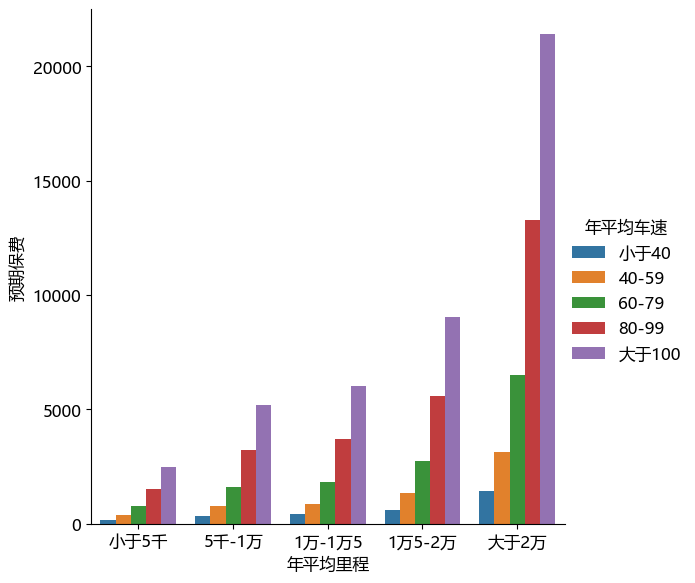

In [71]:
# 聚合取平均并重新排序
plot_df = result.groupby(['年平均里程', '年平均车速']).mean().reset_index()
speed_order = ['小于40', '40-59', '60-79', '80-99', '大于100']
plot_df['年平均车速'] = pd.Categorical(plot_df['年平均车速'], categories=speed_order)
mile_order = ['小于5千', '5千-1万', '1万-1万5', '1万5-2万', '大于2万']
plot_df['年平均里程'] = pd.Categorical(plot_df['年平均里程'], categories=mile_order)
# 绘制簇状条形图查看年平均里程、年平均车速和预期保费的关系
sns.catplot(data=plot_df,
            kind="bar",
            x='年平均里程',
            y='预期保费',
            hue='年平均车速',
            height=6)

由图可以看出，在相同年平均车速的前提下，年平均里程越高，预期保费越高；在相同年平均里程的前提下，年平均车速越高，预期保费越高。在该定价模型下，我们能根据不同用户的驾驶行为给出差异化的保险费率，从而降低我们保险产品的风险，并且为客户提供价格更合理的保险产品。